In [1]:
# Import important libraries
import numpy as np
import math
import matplotlib.pyplot as plt
from kinematics import *
from sensors import *
from utils import *
from LQG import LQG
from time import sleep
import tqdm
from typing import Literal
show_animation = True

# Display the trajectory that the mobile robot executed
plot_dir = './plots/'
import os
os.makedirs(plot_dir, exist_ok=True)

In [2]:
def closed_loop_prediction(desired_traj, landmarks, filter:Literal['EKF', 'KF']='EKF', noise_coeff=1, dt=0.1):
 
    ## Simulation Parameters
    T = desired_traj.shape[0]  # Maximum simulation time
    goal_dis = 0.1 # How close we need to get to the goal
    goal = desired_traj[-1,:] # Coordinates of the goal
    time_0 = 0.0 # Starting time
 
 
    ## Initial States 
    state = np.array([8.3,0.69]) # Initial state of the car
    state_est = state.copy()
 
    ## Get the Cost-to-go and input cost matrices for LQR
    Q = get_Q() # Defined in kinematics.py
    R = get_R() # Defined in kinematics.py
 
    ## Initialize the Car and the Car's landmark sensor 
    DiffDrive = DifferentialDrive(noise_coeff=noise_coeff)
    LandSens = LandmarkDetector(landmarks, noise_coeff=noise_coeff)
         
    # Process noise
    V = DiffDrive.get_V()
    # Sensor measurement noise
    W = LandSens.get_W()
    
    ## Create objects for storing states and estimated state
    t = [time_0]
    traj = np.array([state])
    traj_est = np.array([state_est])
 
    ind = 0
    
    # state dynamics
    A, B = DiffDrive.linearize(dt)
    
    # set up the LQG controller
    lqg = LQG(F=DiffDrive, x_0=state, x_hat_0=state_est, A=A, B=B, 
              sensor=LandSens, Q=Q, R=R, W=W, V=V, H=50, dt=dt, filter=filter)
    
    measurement_err = []
    cost_to_go = []
    
    time_steps = np.arange(time_0, T, dt)
    for time in tqdm.tqdm(time_steps):
         
        ## Point to track
        ind = int(np.floor(time))
        goal_i = desired_traj[ind,:]
 
        ## Generate noise
        # v = process noise, w = measurement noise
        lqg.update_noise()
        
        ## Generate optimal control commands
        lqg.update_lqr(goal_state=goal_i)
 
        ## Move forwad in time
        lqg.forward_state()
        
        # Update the estimate of the state using the EKF
        lqg.update_lqe()
 
        # Store the trajectory and estimated trajectory
        t.append(time)
        state = lqg.x
        state_est = lqg.x_hat
        measure_covar_matrix = lqg.P_lqe
        cost_to_go_matrix = lqg.P_lqr
        # print('error:', (measure_covar_matrix))  
        
        traj = np.concatenate((traj,[state]),axis=0)
        traj_est = np.concatenate((traj_est,[state_est]),axis=0)
        measurement_err.append(np.trace(measure_covar_matrix))
        cost_to_go.append((state_est.T @ cost_to_go_matrix @ state_est).item())
 
        # Check to see if the robot reached goal
        # if np.linalg.norm(state[0:2]-goal[0:2]) <= goal_dis:
        #     print("Goal reached")
        #     break
 
        ## Plot the vehicles trajectory
        # if time % 1 < 0.1 and show_animation:
        #     plt.cla()
        #     plt.plot(desired_traj[:,0], desired_traj[:,1], "-r", label="course")
        #     plt.plot(traj[:,0], traj[:,1], "ob", label="trajectory")
        #     plt.plot(traj_est[:,0], traj_est[:,1], "sk", label="estimated trajectory")

        #     plt.plot(goal_i[0], goal_i[1], "xg", label="target")
        #     plt.axis("equal")
        #     plt.grid(True)
        #     plt.title("SINGAPORE GRAND PRIX\n" + "speed[m/s]:" + str(
        #                                     round(np.mean(lqg.u), 2)) +
        #               ",target index:" + str(ind))
        #     plt.pause(0.0001)
 
        #input()
    return traj, traj_est, measurement_err, cost_to_go, time_steps


100%|██████████| 5610/5610 [00:21<00:00, 262.43it/s]


Time taken for EKF: 21.379180669784546
Time taken for UKF: 22.686925888061523


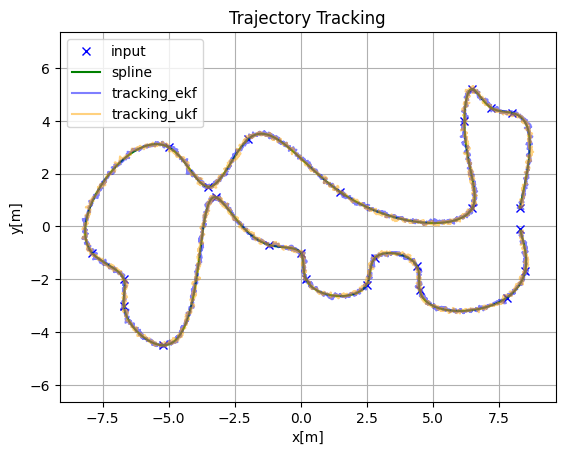

In [3]:

# Create the track waypoints
ax = [8.3,8.0, 7.2, 6.5, 6.2, 6.5, 1.5,-2.0,-3.5,-5.0,-7.9,
-6.7,-6.7,-5.2,-3.2,-1.2, 0.0, 0.2, 2.5, 2.8, 4.4, 4.5, 7.8, 8.5, 8.3]
ay = [0.7,4.3, 4.5, 5.2, 4.0, 0.7, 1.3, 3.3, 1.5, 3.0,-1.0,
-2.0,-3.0,-4.5, 1.1,-0.7,-1.0,-2.0,-2.2,-1.2,-1.5,-2.4,-2.7,-1.7,-0.1]

# These landmarks help the mobile robot localize itself
landmarks = [[0,0],
             [4,5],
             [2,9]]
    
# Compute the desired trajectory
desired_traj = compute_traj(ax,ay)
noise = 0.1
dt = 0.1
# timer
import time

start = time.time()
pred_traj_ukf, est_traj_ekf, err_ukf, cost_ukf, time_steps = closed_loop_prediction(desired_traj,landmarks, filter='UKF', noise_coeff=noise, dt=dt)
time_ukf = time.time() - start

start = time.time()
pred_traj_ekf, est_traj_ukf, err_ekf, cost_ekf, time_steps = closed_loop_prediction(desired_traj,landmarks, filter='EKF', noise_coeff=noise, dt=dt)
time_ekf = time.time() - start

# dispaly the time taken for each filter
print('Time taken for EKF:', time_ekf)
print('Time taken for UKF:', time_ukf)
# tracking paths
plt.plot(ax, ay, "xb", label="input")
# half transparency
plt.plot(desired_traj[:,0], desired_traj[:,1], label="spline", color = 'green')
plt.plot(est_traj_ekf[:,0], est_traj_ekf[:,1], label="tracking_ekf", color='blue', alpha=0.5)
plt.plot(est_traj_ukf[:,0], est_traj_ukf[:,1], label="tracking_ukf", color='orange', alpha=0.5)
plt.grid(True)
plt.axis("equal")
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.legend()
plt.title("Trajectory Tracking")
plt.show()

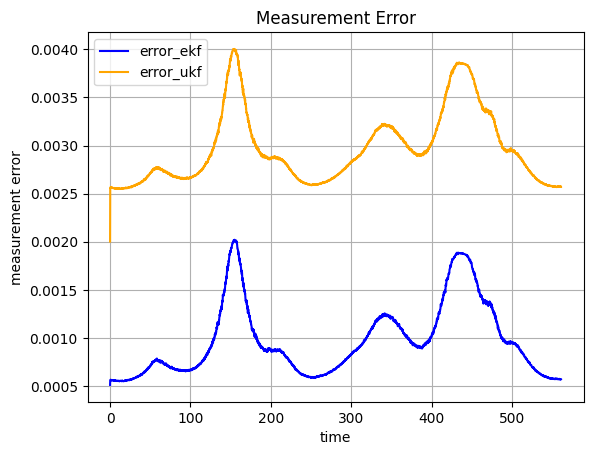

In [4]:
# error
plt.plot(time_steps[:len(err_ekf)], err_ekf, label="error_ekf", color='blue')
plt.plot(time_steps[:len(err_ukf)], err_ukf, label="error_ukf", color='orange')
plt.grid(True)
plt.xlabel("time")
plt.ylabel("measurement error")
plt.legend()
plt.title("Measurement Error")
plt.show()

t = 5610


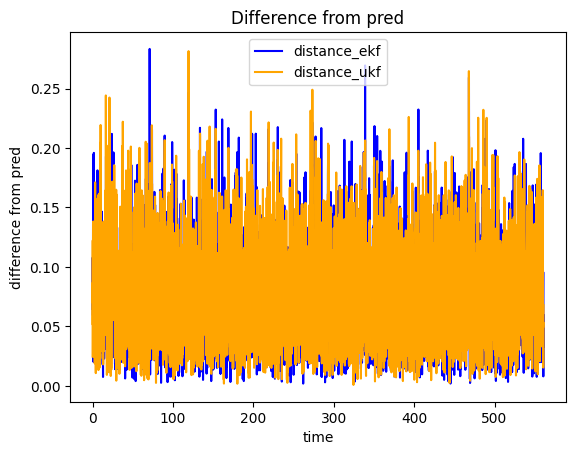

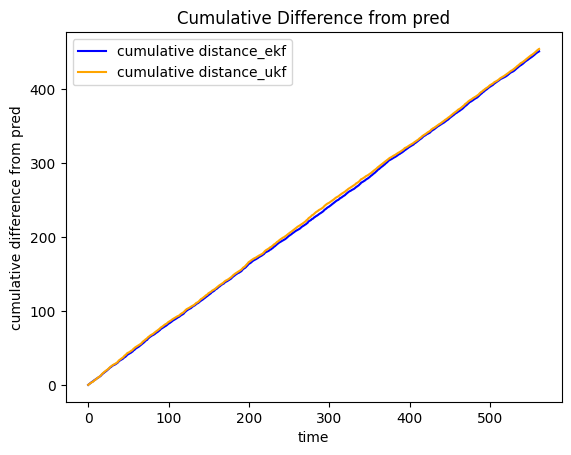

In [10]:
# distance from pred
# Compute the distance between the desired trajectory and the estimated trajectory
t = min(len(pred_traj_ekf), len(est_traj_ekf), len(time_steps))
print('t =', t)
dist_pred_ekf = [math.sqrt((pred_traj_ekf[i,0] - est_traj_ekf[i+1,0])**2 + (pred_traj_ekf[i,1] - est_traj_ekf[i+1,1])**2) for i in range(t)]
dist_pred_ukf = [math.sqrt((pred_traj_ukf[i,0] - est_traj_ukf[i+1,0])**2 + (pred_traj_ukf[i,1] - est_traj_ukf[i+1,1])**2) for i in range(t)]

plt.plot(time_steps[:t], dist_pred_ekf, label="distance_ekf", color='blue')
plt.plot(time_steps[:t], dist_pred_ukf, label="distance_ukf", color='orange')
plt.xlabel("time")
plt.ylabel("difference from pred")
plt.legend()
plt.title("Difference from pred")
plt.show()

# cumulative distance from pred
cum_dist_pred_ekf = np.cumsum(dist_pred_ekf)
cum_dist_pred_ukf = np.cumsum(dist_pred_ukf)
plt.plot(time_steps[:t], cum_dist_pred_ekf, label="cumulative distance_ekf", color='blue')
plt.plot(time_steps[:t], cum_dist_pred_ukf, label="cumulative distance_ukf", color='orange')
plt.xlabel("time")
plt.ylabel("cumulative difference from pred")
plt.legend()
plt.title("Cumulative Difference from pred")
plt.show()

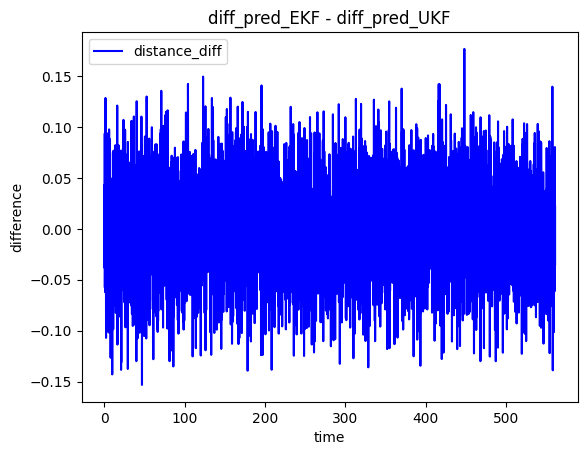

In [ ]:
# distance difference
dist_diff = [dist_pred_ekf[i] - dist_pred_ukf[i] for i in range(t)]
plt.plot(time_steps[:t], dist_diff, label="distance_diff", color='blue')
plt.xlabel("time")
plt.ylabel("difference")
plt.legend()
plt.title("diff_pred_EKF - diff_pred_UKF")
plt.show()


561 5611
t = 561


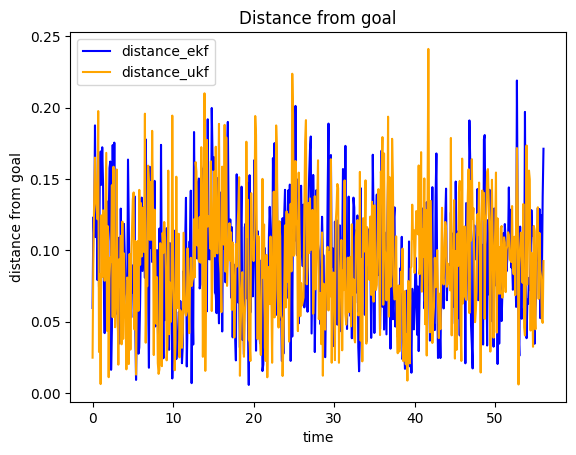

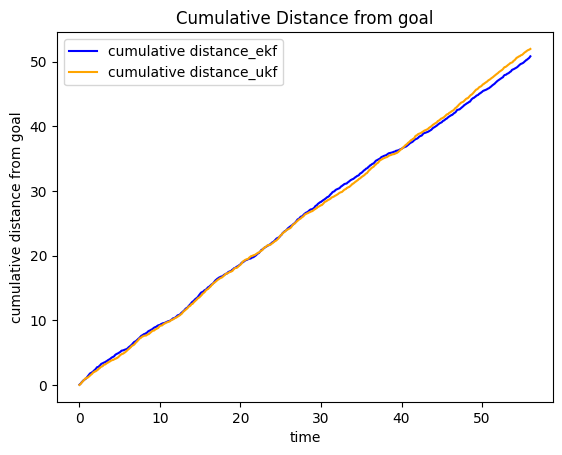

In [11]:
# distance from goal
# Compute the distance between the desired trajectory and the estimated trajectory
t = min(len(desired_traj), len(est_traj_ekf))
print(len(desired_traj), len(est_traj_ekf))
print('t =', t)
dist_goal_ekf = [math.sqrt((desired_traj[i,0] - est_traj_ekf[i*10 + 1,0])**2 + (desired_traj[i,1] - est_traj_ekf[i*10 + 1,1])**2) for i in range(t)]
dist_goal_ukf = [math.sqrt((desired_traj[i,0] - est_traj_ukf[i*10 + 1,0])**2 + (desired_traj[i,1] - est_traj_ukf[i*10 + 1,1])**2) for i in range(t)]
plt.plot(time_steps[:t], dist_goal_ekf, label="distance_ekf", color='blue')
plt.plot(time_steps[:t], dist_goal_ukf, label="distance_ukf", color='orange')
plt.xlabel("time")
plt.ylabel("distance from goal")
plt.legend()
plt.title("Distance from goal")
plt.show()

# cumulative distance from goal
cum_dist_goal_ekf = np.cumsum(dist_goal_ekf)
cum_dist_goal_ukf = np.cumsum(dist_goal_ukf)
plt.plot(time_steps[:t], cum_dist_goal_ekf, label="cumulative distance_ekf", color='blue')
plt.plot(time_steps[:t], cum_dist_goal_ukf, label="cumulative distance_ukf", color='orange')
plt.xlabel("time")
plt.ylabel("cumulative distance from goal")
plt.legend()
plt.title("Cumulative Distance from goal")
plt.show()

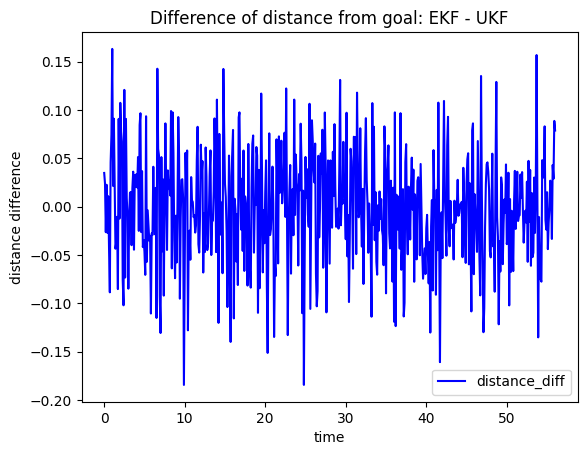

In [8]:
# distance difference
dist_diff = [dist_goal_ekf[i] - dist_goal_ukf[i] for i in range(t)]
plt.plot(time_steps[:t], dist_diff, label="distance_diff", color='blue')
plt.xlabel("time")
plt.ylabel("distance difference")
plt.legend()
plt.title("Difference of distance from goal: EKF - UKF")
plt.show()

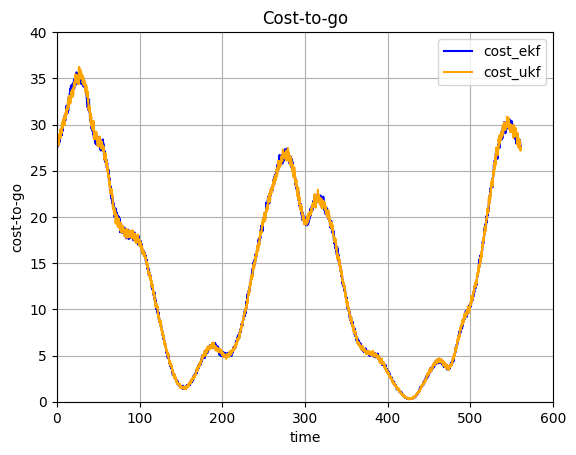

In [9]:
# cost
plt.plot(time_steps[:len(cost_ekf)], cost_ekf, label="cost_ekf", color='blue')
plt.plot(time_steps[:len(cost_ukf)], cost_ukf, label="cost_ukf", color='orange')
plt.grid(True)
plt.xlabel("time")    
plt.ylabel("cost-to-go")
plt.xlim(0, 600)
plt.ylim(0, 40)
plt.legend()
plt.title("Cost-to-go")
plt.show()